In [1]:
import os
import cv2
import tensorflow as tf
from typing import List
from matplotlib import pyplot as plt
import imageio

In [2]:
# prevent exponentional memory growth
physical_devices = tf.config.list_logical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0],True)
except:
    pass

In [ ]:
# two build functions one for image and one for dataset
import gdown

url = "https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL"
output = 'data.zip'
gdown.download(url,output, quiet=False)
gdown.extractall('data.zip')

In [3]:
def load_video(path:str) -> List[float]:
    # input the video path and return a list of frames
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    # we normalize the frames
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean),tf.float32)/std


In [4]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!1234567890"]

In [5]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="",invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()}"
    f"(size={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0'](size=40)


In [6]:
def load_alignments(path:str) -> List[str]:
    with open(path,'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        # dont consider silences
        if line[2] != 'sil':
            # appending the words as token to existing tokens(words)
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:]

In [7]:
def load_data(path: str):
    # loading the data using path sent as a tensor
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames,alignments

In [8]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [9]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8')

'.\\data\\s1\\bbal6n.mpg'

In [10]:
frames,alignments = load_data(tf.convert_to_tensor(test_path))

In [11]:
print(frames)

tf.Tensor(
[[[[ 1.4603739 ]
   [ 1.4603739 ]
   [ 1.4209043 ]
   ...
   [ 0.15787826]
   [ 0.19734782]
   [ 0.07893913]]

  [[ 1.4603739 ]
   [ 1.4603739 ]
   [ 1.4209043 ]
   ...
   [ 0.15787826]
   [ 0.07893913]
   [ 0.03946957]]

  [[ 1.4209043 ]
   [ 1.4209043 ]
   [ 1.3814348 ]
   ...
   [ 0.07893913]
   [ 0.07893913]
   [ 0.07893913]]

  ...

  [[ 0.94726956]
   [ 0.94726956]
   [ 0.94726956]
   ...
   [ 9.94633   ]
   [ 9.867392  ]
   [ 9.867392  ]]

  [[ 0.94726956]
   [ 0.94726956]
   [ 0.94726956]
   ...
   [ 9.90686   ]
   [ 9.867392  ]
   [ 9.867392  ]]

  [[ 0.94726956]
   [ 0.94726956]
   [ 0.94726956]
   ...
   [ 9.90686   ]
   [ 9.867392  ]
   [ 9.867392  ]]]


 [[[ 1.4209043 ]
   [ 1.4209043 ]
   [ 1.3419652 ]
   ...
   [ 0.19734782]
   [ 0.11840869]
   [ 0.15787826]]

  [[ 1.4209043 ]
   [ 1.4209043 ]
   [ 1.3419652 ]
   ...
   [ 0.23681739]
   [ 0.        ]
   [ 0.03946957]]

  [[ 1.3419652 ]
   [ 1.3419652 ]
   [ 1.3024956 ]
   ...
   [ 0.11840869]
   [ 0.15787826]


tf.Tensor(
[[[1.4603739 ]
  [1.4603739 ]
  [1.4209043 ]
  ...
  [0.15787826]
  [0.19734782]
  [0.07893913]]

 [[1.4603739 ]
  [1.4603739 ]
  [1.4209043 ]
  ...
  [0.15787826]
  [0.07893913]
  [0.03946957]]

 [[1.4209043 ]
  [1.4209043 ]
  [1.3814348 ]
  ...
  [0.07893913]
  [0.07893913]
  [0.07893913]]

 ...

 [[0.94726956]
  [0.94726956]
  [0.94726956]
  ...
  [9.94633   ]
  [9.867392  ]
  [9.867392  ]]

 [[0.94726956]
  [0.94726956]
  [0.94726956]
  ...
  [9.90686   ]
  [9.867392  ]
  [9.867392  ]]

 [[0.94726956]
  [0.94726956]
  [0.94726956]
  ...
  [9.90686   ]
  [9.867392  ]
  [9.867392  ]]], shape=(46, 140, 1), dtype=float32)


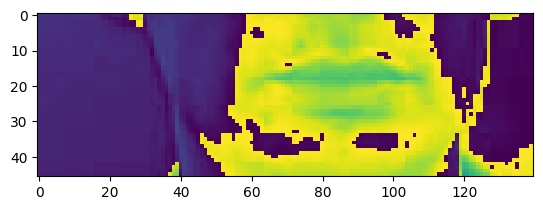

In [12]:
plt.imshow(frames[0])
print(frames[0])

In [13]:
bytes.decode(tf.strings.reduce_join([x for x in num_to_char(alignments)]).numpy())

'binblueatlsixnow'

In [68]:
# helps use to get data from file name
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_video, [path],(tf.float32,tf.int64))
    return result

In [49]:
#make a datapipeline

data = tf.data.Dataset.list_files('./data/s1/*.mpg')
# get 500 files
data = data.shuffle(500,reshuffle_each_iteration=False)
data = data.map(mappable_function)
# using batches of 2 and padding the data to avoid uneven shape of alignment and frames
data = data.padded_batch(2,padded_shapes=([75,None,None,None],[40]))
# prefetching the data to avoid bottleneck
data = data.prefetch(tf.data.AUTOTUNE)

train = data.take(450)
test = data.skip(450)

In [16]:
len(test)

50

In [22]:
frames, alignments = data.as_numpy_iterator().next()

In [23]:
alignments

array([[ 2,  9, 14,  0, 23,  8,  9, 20,  5,  0,  2, 25,  0, 20,  0, 14,
         9, 14,  5,  0,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [24]:
print(frames.shape)

(1, 75, 46, 140, 1)


In [25]:
test = data.as_numpy_iterator()

# test has and array of [frames,alignments] inside those we have 2 video frames and 2 alignments

In [27]:
val = test.next(); 
val[0]

array([[[[[1.5059857 ],
          [1.5059857 ],
          [1.3957916 ],
          ...,
          [0.40404496],
          [0.40404496],
          [0.40404496]],

         [[1.5059857 ],
          [1.3590603 ],
          [1.3590603 ],
          ...,
          [0.40404496],
          [0.40404496],
          [0.40404496]],

         [[1.432523  ],
          [1.432523  ],
          [1.432523  ],
          ...,
          [0.33058223],
          [0.2571195 ],
          [0.2571195 ]],

         ...,

         [[1.0652094 ],
          [1.0652094 ],
          [1.0652094 ],
          ...,
          [0.14692543],
          [0.14692543],
          [0.14692543]],

         [[1.0652094 ],
          [1.0652094 ],
          [1.0652094 ],
          ...,
          [0.11019408],
          [0.11019408],
          [0.11019408]],

         [[1.0652094 ],
          [1.0652094 ],
          [1.0652094 ],
          ...,
          [0.11019408],
          [0.11019408],
          [0.07346272]]],


        [[[1.4692

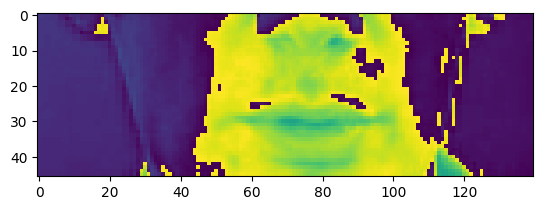

In [33]:
plt.imshow(val[0][0][30])

In [35]:
tf.strings.reduce_join([num_to_char(word) for word in val[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'placewhitewithezeronow'>

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D,LSTM,Dense,Dropout,Bidirectional, MaxPool3D,Reshape,SpatialDropout3D,BatchNormalization,TimeDistributed,Flatten,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [37]:
model = Sequential()
# conv3D used for video processing input shape is the shape of each frame and 128 output filters and 3 is 3d kernel size
model.add(Conv3D(128,3,input_shape=(75,46,140,1),padding='same'))
# to get some non linearities
model.add(Activation('relu'))
# takes max values of each frame and condences into 2x2 kernel
model.add(MaxPool3D((1,2,2)))

# 2nd layer with 256 output filters
model.add(Conv3D(256,3,padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75,3,padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

# flatten the output to feed into dense layer
model.add(TimeDistributed(Flatten()))

# 2 layer LSTM
# return_sequences=True means it will return the output of each time step
# dropout to prevent overfitting
# kernel_initializer='Orthogonal' to prevent vanishing gradient problem
# 128 is the number of hidden units
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal',return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal',return_sequences=True)))
model.add(Dropout(.5))

# dense layer with softmax activation
# output in the form of one hot encoding of the characters in the vocabulary + 1 for blank character
# using softmax activation to get the probability of each character then take the max probability using argmax
model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal',activation='softmax'))

In [38]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [40]:
# test prediction
yhat = model.predict(val[0])

1/1 [==============================] - 13s 13s/step


In [42]:
bytes.decode(tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat]).numpy())

'3y8afuaa56anae'

In [43]:
# function to define learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr*tf.math.exp(-0.1)

In [44]:
def CTCLoss(y_true,y_pred):
    # loss function for CTC. used for training to reduce the loss
    batch_len = tf.cast(tf.shape(y_true)[0],dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1],dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1],dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len,1),dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len,1),dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true,y_pred,input_length,label_length)
    return loss

In [45]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self,dataset):
        self.dataset = dataset.as_numpy_iterator()
    # on epoch end, print an example of text prediction
    def on_epoch_end(self, epoch, logs=None):
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat,[75,75],greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [46]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
# typical keras model compilation
model.compile(optimizer,loss=CTCLoss)

In [47]:
# to store the model checkpoints
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'),monitor='loss',save_weights_only=True)

In [50]:
# used to drop the learning rate after a certain number of epochs
schedule_callback = LearningRateScheduler(scheduler)
# used to print the example predictions
example_callback = ProduceExample(test)

In [ ]:
# trainning the model
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

In [51]:
# loading a trained model
model.load_weights('models/checkpoint')

In [52]:
test_data = test.as_numpy_iterator()

In [53]:
sample = test_data.next()

In [54]:
print(sample[0].shape)

(1, 75, 46, 140, 1)


In [55]:
yhat = model.predict(sample[0])

1/1 [==============================] - 9s 9s/step


In [56]:
print(yhat.shape)

(1, 75, 41)


In [61]:
decoded = tf.keras.backend.ctc_decode(yhat,input_length=[75], greedy=True)[0][0].numpy()

In [62]:
print('~'*100,'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'setwhiteatueightnow'>]

In [63]:
print('~'*100,'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set0white0at0u0eight0now'>]